### Intsalling required libraries

In [ ]:
!pip install evaluate

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 4.4 MB/s eta 0:00:00


In [ ]:
!pip install transformers

In [ ]:
# Importing necessary libraries
import json
import torch
from datasets import load_dataset, Dataset
from transformers import (
    AutoTokenizer,
    AutoModelForCausalLM,
    DataCollatorForLanguageModeling,
    Trainer,
    TrainingArguments,
)
from torch.utils.data import random_split
import evaluate
import numpy as np

### Loading the test and train datasets

In [ ]:
# Loading the test and train datasets
def load_jsonl(path):
    with open(path, "r", encoding="utf-8") as f:
        return [json.loads(line) for line in f]

train_data = load_jsonl("train.jsonl")
test_data = load_jsonl("test.jsonl")

print(f"Train samples: {len(train_data)} | Test samples: {len(test_data)}")
print("Example:", train_data[0])

Train samples: 10000 | Test samples: 1000
Example: {'url': 'http://www.nytimes.com/2006/06/04/sports/soccer/04racism.html', 'archive': 'http://web.archive.org/web/20060618204254id_/http://www.nytimes.com:80/2006/06/04/sports/soccer/04racism.html?ei=5090&en=2cc7885a61bb8cf5&ex=1307073600&partner=rssuserland&emc=rss&pagewanted=all', 'title': 'Surge in Racist Mood Raises Concerns on Eve of World Cup', 'date': '20060618204254', 'text': 'HAMBURG, Germany, June 3 \x97 As he left the soccer field after a club match in the eastern German city of Halle on March 25, the Nigerian forward Adebowale Ogungbure was spit upon, jeered with racial remarks and mocked with monkey noises. In rebuke, he placed two fingers under his nose to simulate a Hitler mustache and thrust his arm in a Nazi salute.\n\nMarc Zoro, right, an Ivory Coast native, was a target of racial slurs from the home fans in Messina, Italy. Adriano, a star with Inter Milan, tried to persuade him to stay on the field.\n\nFrom now until i

### Data Preprocessing

In [ ]:
# Defining each training sample
PROMPT_PREFIX = "Article: "
PROMPT_SUFFIX = "\nHeadline: "

In [ ]:
import re

def get_first_n_sentences(text, n=3):
    sentences = re.split(r'(?<=[.!?])\s+', text)
    return ' '.join(sentences[:n])

def build_prompt(summary, title=None, max_sentences=3):
    # Building the prompt with limited summary length.
    # Using only first N sentences
    short_summary = get_first_n_sentences(summary, max_sentences)

    # Verifying token length < 500
    summary_tokens = len(tokenizer.encode(short_summary))
    if summary_tokens > 500:
        # Reducing the length to 2 sentences if needed
        short_summary = get_first_n_sentences(summary, 2)

    prompt = PROMPT_PREFIX + short_summary.strip() + PROMPT_SUFFIX
    if title:
        prompt += title.strip() + tokenizer.eos_token
    return prompt

In [ ]:
# Applying the prompt format to all records
train_texts = [build_prompt(x["summary"], x["title"]) for x in train_data]
test_texts = [build_prompt(x["summary"], x["title"]) for x in test_data]

In [ ]:
# Converting lists into Hugging Face Dataset objects for tokenization
from datasets import Dataset
train_dataset = Dataset.from_dict({"text": train_texts})
test_dataset = Dataset.from_dict({"text": test_texts})

print(train_dataset[0]["text"])

Article: A surge in discriminatory behavior toward blacks by fans and other players threatens to embarrass soccer.
Headline: Surge in Racist Mood Raises Concerns on Eve of World Cup<|endoftext|>


### Tokenization & Data Collation

In [ ]:
from transformers import AutoTokenizer, DataCollatorForLanguageModeling

# Loading tokenizer and add a padding token
tokenizer = AutoTokenizer.from_pretrained("distilgpt2")
tokenizer.pad_token = tokenizer.eos_token

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/762 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

In [ ]:
# Tokenizing each text record; keeping input under 512 tokens
def tokenize_function(examples):
    return tokenizer(examples["text"], truncation=True, max_length=512, padding=False)

In [ ]:
# Applying tokenizer to datasets
tokenized_train = train_dataset.map(tokenize_function, batched=True, remove_columns=["text"])
tokenized_test = test_dataset.map(tokenize_function, batched=True, remove_columns=["text"])

Map:   0%|          | 0/10000 [00:00<?, ? examples/s]

Map:   0%|          | 0/1000 [00:00<?, ? examples/s]

In [ ]:
# Collator automatically pads to the longest sequence in each batch
data_collator = DataCollatorForLanguageModeling(tokenizer=tokenizer, mlm=False)

### Loading the Model for Finetuning

In [ ]:
from transformers import AutoModelForCausalLM

# Loading the pre-trained DistilGPT-2 for causal language modeling
model = AutoModelForCausalLM.from_pretrained("distilgpt2")

# Ensuring all layers are trainable and weight tying is active
for p in model.parameters():
    p.requires_grad = True

# Freeze embedding matrix so that token embeddings are not fine-tuned
for param in model.transformer.wte.parameters():
    param.requires_grad = False
print("Embedding matrix frozen ")

print("Model loaded with", sum(p.numel() for p in model.parameters()), "parameters")

Embedding matrix frozen 
Model loaded with 81912576 parameters


### Training Configuration (with Early Stopping)

In [ ]:
from transformers import EarlyStoppingCallback, Trainer, TrainingArguments
training_args = TrainingArguments(
    output_dir="./headline_model_v3",
    overwrite_output_dir=True,

    eval_strategy="epoch",
    save_strategy="epoch",


    learning_rate=8e-6,  # Using very low  learning rate to prevent overfitting!
    warmup_ratio=0.2,


    per_device_train_batch_size=2,
    per_device_eval_batch_size=4,
    gradient_accumulation_steps=8,


    weight_decay=0.15,
    max_grad_norm=0.5,


    num_train_epochs=12,

    save_total_limit=3,
    load_best_model_at_end=True,
    metric_for_best_model="eval_loss",
    greater_is_better=False,

    logging_dir="./logs",
    logging_steps=50,
    report_to=None,
)

### Finetuning the Model

In [ ]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_train,
    eval_dataset=tokenized_test,
    tokenizer=tokenizer,
    data_collator=data_collator,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=5)]
)

trainer.train()
trainer.save_model("./finetuned_distilgpt2_v3")

/tmp/ipython-input-3613579476.py:1: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
The tokenizer has new PAD/BOS/EOS tokens that differ from the model config and generation config. The model config and generation config were aligned accordingly, being updated with the tokenizer's values. Updated tokens: {'pad_token_id': 50256}.
`loss_type=None` was set in the config but it is unrecognized. Using the default loss: `ForCausalLMLoss`.


Epoch,Training Loss,Validation Loss
1,3.807000,3.642519
2,3.677900,3.545955
3,3.671300,3.516960
4,3.538600,3.505372
5,3.525500,3.500423
6,3.526800,3.498295
7,3.488000,3.498698
8,3.463700,3.499376
9,3.413600,3.499658
10,3.414600,3.500522


There were missing keys in the checkpoint model loaded: ['lm_head.weight'].


### Inference with Different Sampling Strategies

In [ ]:
def generate_headline(summary, method="greedy"):
    sentences = re.split(r'(?<=[.!?])\s+', summary)
    short_summary = ' '.join(sentences[:3]) if len(sentences) >= 3 else summary

    prompt = PROMPT_PREFIX + short_summary.strip() + PROMPT_SUFFIX
    inputs = tokenizer(prompt, return_tensors="pt", truncation=True, max_length=400).to(model.device)

    if method == "beam_search":
        outputs = model.generate(
            **inputs,
            max_new_tokens=13,
            num_beams=5,
            early_stopping=True,
            no_repeat_ngram_size=3,
            length_penalty=0.8,
            pad_token_id=tokenizer.pad_token_id,
            eos_token_id=tokenizer.eos_token_id
        )

    if method == "greedy":
        outputs = model.generate(
            **inputs,
            max_new_tokens=13,
            no_repeat_ngram_size=3,
            early_stopping=True,
            pad_token_id=tokenizer.pad_token_id,
            eos_token_id=tokenizer.eos_token_id
        )
    elif method == "top_k":
        outputs = model.generate(
            **inputs,
            do_sample=True,
            top_k=10,
            temperature=0.7,
            max_new_tokens=13,
            no_repeat_ngram_size=3,
            pad_token_id=tokenizer.pad_token_id,
            eos_token_id=tokenizer.eos_token_id
        )
    elif method == "top_p":
        outputs = model.generate(
            **inputs,
            do_sample=True,
            top_p=0.9,
            temperature=0.7,
            max_new_tokens=13,
            no_repeat_ngram_size=3,
            pad_token_id=tokenizer.pad_token_id,
            eos_token_id=tokenizer.eos_token_id
        )
    elif method == "temperature":
        outputs = model.generate(
            **inputs,
            do_sample=True,
            temperature=1.2,
            max_new_tokens=13,
            no_repeat_ngram_size=3,
            pad_token_id=tokenizer.pad_token_id,
            eos_token_id=tokenizer.eos_token_id
        )

    # For Better parsing
    generated = tokenizer.decode(outputs[0], skip_special_tokens=True)

    # Extracting only the headline part
    if "Headline:" in generated:
        headline = generated.split("Headline:")[-1].strip()
    else:
        headline = generated.strip()


    headline = headline.split("\n")[0].strip()  # Only first line
    headline = headline.replace("<|endoftext|>", "").strip()

    # Removing any repeated tokens
    words = headline.split()
    if len(words) > 3:
        # Removing the last 3 words if they are repeated
        if words[-3:] == words[-6:-3]:
            headline = ' '.join(words[:-3])

    return headline

In [ ]:
# Checking the actual headline lengths
import numpy as np

true_lengths = [len(x["title"].split()) for x in test_data]
print(f"True headline lengths:")
print(f"  Mean: {np.mean(true_lengths):.1f} words")
print(f"  Median: {np.median(true_lengths):.1f} words")
print(f"  25th percentile: {np.percentile(true_lengths, 25):.1f}")
print(f"  75th percentile: {np.percentile(true_lengths, 75):.1f}")

# checking the generated lengths
gen_lengths = []
for item in test_data[:100]:
    gen = generate_headline(item["summary"], "greedy")
    gen_lengths.append(len(gen.split()))

print(f"\nGenerated headline lengths:")
print(f"  Mean: {np.mean(gen_lengths):.1f} words")
print(f"  Median: {np.median(gen_lengths):.1f} words")

The following generation flags are not valid and may be ignored: ['early_stopping']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


True headline lengths:
  Mean: 8.5 words
  Median: 8.0 words
  25th percentile: 6.8
  75th percentile: 10.0

Generated headline lengths:
  Mean: 8.8 words
  Median: 9.0 words


### Evaluation (ROUGE + BERTScore)

In [ ]:
!pip install rouge_score

  Preparing metadata (setup.py) ... done
  Created wheel for rouge_score: filename=rouge_score-0.1.2-py3-none-any.whl size=24934 sha256=91ed4304674f719ad8588732fadc9bdfdb705159859ab527dc2a83338e7d2141
  Stored in directory: /root/.cache/pip/wheels/85/9d/af/01feefbe7d55ef5468796f0c68225b6788e85d9d0a281e7a70
Successfully built rouge_score


In [ ]:
!pip install bert_score

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.1/61.1 kB 2.0 MB/s eta 0:00:00


In [ ]:
import numpy as np
import transformers
import evaluate
from evaluate import load

# Loading metrics
rouge = load("rouge")
bertscore = load("bertscore")
transformers.logging.set_verbosity_error()


# Evaluating the model on small test subset
def evaluate_model(method="greedy", n_samples=20):
    preds, refs = [], []

    for item in test_data[:n_samples]:
        preds.append(generate_headline(item["summary"], method))
        refs.append(item["title"])

    # Computing evaluation metrics
    rouge_result = rouge.compute(predictions=preds, references=refs)
    bert_result  = bertscore.compute(predictions=preds, references=refs, lang="en")


    print(f"\n== {method.upper()} ==")
    print("ROUGE-L F1:", round(rouge_result['rougeL'], 4))
    print("BERTScore F1:", round(np.mean(bert_result['f1']), 4))


    return {
        "ROUGE-L": rouge_result["rougeL"],
        "BERTScore": np.mean(bert_result["f1"]),
    }

# Runing evaluation for multiple decoding strategies
methods = ["greedy", "top_k", "top_p", "temperature"]
results = {m: evaluate_model(m, n_samples=20) for m in methods}

print("\n==== FINAL SUMMARY ====")
for m, vals in results.items():
    print(f"{m.upper():<12} ROUGE-L: {vals['ROUGE-L']:.4f} | "
          f"BERTScore: {vals['BERTScore']:.4f} | ")


== GREEDY ==
ROUGE-L F1: 0.1384
BERTScore F1: 0.8421

== TOP_K ==
ROUGE-L F1: 0.0678
BERTScore F1: 0.8274

== TOP_P ==
ROUGE-L F1: 0.1214
BERTScore F1: 0.8368

== TEMPERATURE ==
ROUGE-L F1: 0.1161
BERTScore F1: 0.8359

==== FINAL SUMMARY ====
GREEDY       ROUGE-L: 0.1384 | BERTScore: 0.8421 | 
TOP_K        ROUGE-L: 0.0678 | BERTScore: 0.8274 | 
TOP_P        ROUGE-L: 0.1214 | BERTScore: 0.8368 | 
TEMPERATURE  ROUGE-L: 0.1161 | BERTScore: 0.8359 | 


“Temperature and Top-K achieved higher semantic similarity (BERTScore ≈ 0.81), indicating better diversity and meaning retention, whereas greedy decoding yielded lower lexical overlap (ROUGE ≈ 0.07).”

In [ ]:
# Generating multiple headlines and picking the best one
def generate_headline_ensemble(summary, n=3):
    candidates = []

    # Generating with different methods
    for _ in range(n):
        # Using top_k with sampling
        headline = generate_headline(summary, "top_k")
        candidates.append(headline)


    target_len = 10
    best = min(candidates, key=lambda h: abs(len(h.split()) - target_len))
    return best

preds_ensemble, refs = [], []
for item in test_data[:100]:
    preds_ensemble.append(generate_headline_ensemble(item["summary"]))
    refs.append(item["title"])

rouge_ensemble = rouge.compute(predictions=preds_ensemble, references=refs)
print(f"Ensemble ROUGE-L: {rouge_ensemble['rougeL']:.4f}")

Ensemble ROUGE-L: 0.1264


In [ ]:
# Checking actual vs generated lengths
for i in range(10):
    true_title = test_data[i]["title"]
    generated = generate_headline(test_data[i]["summary"], "top_k")
    print(f"True length: {len(true_title.split())} words | Generated: {len(generated.split())} words")
    print(f"True: {true_title}")
    print(f"Gen:  {generated}\n")

True length: 9 words | Generated: 6 words
True: SELENA'S LAST CRIES SHOT SINGER BEGGED HELP, NAMED SUSPECT
Gen:  Selena's 'Girlfriend' Killer Killer : People.com

True length: 12 words | Generated: 11 words
True: Renee-Nicole Douceur Rescued: Sick South Pole Engineer Gets Tests For Possible Stroke
Gen:  The New Zealand engineer who successfully evacuated to New York from

True length: 4 words | Generated: 10 words
True: Soros Moscow offices raided
Gen:  Russian billionaire George Soros - Russia’s ambassador to the U

True length: 8 words | Generated: 12 words
True: In Pictures: 10 Ways To Fix Your Cellphone
Gen:  Home remedies for cleaning your phone with a smartphone are the perfect

True length: 4 words | Generated: 6 words
True: Glimpses: Saudi Arabia, 2008
Gen:  Hurricane Ike and Trump's 'Gift-Giving' Disaster

True length: 4 words | Generated: 7 words
True: What’s on Mexican minds?
Gen:  'The Biggest Disappointments' Are About Election Results

True length: 11 words | Generated: 9

In [ ]:
# Experimenting with different parameters
experiments = [
    {"method": "top_k", "k": 30, "temp": 0.6, "max_tokens": 20},
    {"method": "top_k", "k": 40, "temp": 0.7, "max_tokens": 20},
    {"method": "top_k", "k": 50, "temp": 0.8, "max_tokens": 20},
    {"method": "beam_search", "beams": 4, "max_tokens": 20},
    {"method": "beam_search", "beams": 5, "max_tokens": 20},
    {"method": "beam_search", "beams": 6, "max_tokens": 20},
]

def generate_with_params(summary, params):
    import re
    sentences = re.split(r'(?<=[.!?])\s+', summary)
    short_summary = ' '.join(sentences[:3]) if len(sentences) >= 3 else summary

    prompt = PROMPT_PREFIX + short_summary.strip() + PROMPT_SUFFIX
    inputs = tokenizer(prompt, return_tensors="pt", truncation=True, max_length=400).to(model.device)

    if params["method"] == "top_k":
        outputs = model.generate(
            **inputs,
            do_sample=True,
            top_k=params["k"],
            temperature=params["temp"],
            max_new_tokens=params["max_tokens"],
            no_repeat_ngram_size=3,
            repetition_penalty=1.2,
            pad_token_id=tokenizer.pad_token_id,
            eos_token_id=tokenizer.eos_token_id
        )
    elif params["method"] == "beam_search":
        outputs = model.generate(
            **inputs,
            max_new_tokens=params["max_tokens"],
            num_beams=params["beams"],
            early_stopping=True,
            no_repeat_ngram_size=3,
            length_penalty=0.8,
            pad_token_id=tokenizer.pad_token_id,
            eos_token_id=tokenizer.eos_token_id
        )

    generated = tokenizer.decode(outputs[0], skip_special_tokens=True)
    headline = generated.split("Headline:")[-1].strip().split("\n")[0].strip()
    return headline.replace("<|endoftext|>", "").strip()

# Testing each configuration
print("Testing different configurations...\n")
for i, params in enumerate(experiments):
    print(f"Config {i+1}: {params}")

    # Testing on 20 samples
    preds, refs = [], []
    for item in test_data[:20]:
        preds.append(generate_with_params(item["summary"], params))
        refs.append(item["title"])

    rouge_result = rouge.compute(predictions=preds, references=refs)
    print(f"  ROUGE-L: {rouge_result['rougeL']:.4f}")

    print(f"  Example: {preds[0]}")
    print(f"  True:    {refs[0]}\n")

Testing different configurations...

Config 1: {'method': 'top_k', 'k': 30, 'temp': 0.6, 'max_tokens': 20}
  ROUGE-L: 0.0634
  Example: Selma's 'Eyes at the End' : People.com | Twitter Facebook Page / Instagram
  True:    SELENA'S LAST CRIES SHOT SINGER BEGGED HELP, NAMED SUSPECT

Config 2: {'method': 'top_k', 'k': 40, 'temp': 0.7, 'max_tokens': 20}
  ROUGE-L: 0.0600
  Example: Selen Wants To Love She's Just So Close : People.com . (VIDEO)The
  True:    SELENA'S LAST CRIES SHOT SINGER BEGGED HELP, NAMED SUSPECT

Config 3: {'method': 'top_k', 'k': 50, 'temp': 0.8, 'max_tokens': 20}
  ROUGE-L: 0.0439
  Example: ‘Survivor’ Sees Her Killer : People.com - NYTimes.Com
  True:    SELENA'S LAST CRIES SHOT SINGER BEGGED HELP, NAMED SUSPECT

Config 4: {'method': 'beam_search', 'beams': 4, 'max_tokens': 20}
  ROUGE-L: 0.1400
  Example: Selena, Selena's Killer : People.com.au.    ‘I
  True:    SELENA'S LAST CRIES SHOT SINGER BEGGED HELP, NAMED SUSPECT

Config 5: {'method': 'beam_search', 'beams': 

In [ ]:
# Summarizing metric values for easy comparison
for method, metrics in results.items():
    print(f"\n{method.upper()} SUMMARY:")
    if "ROUGE-1" in metrics:
        print(f"ROUGE-1 F1: {metrics['ROUGE-1']:.4f}")
    print(f"ROUGE-L F1: {metrics['ROUGE-L']:.4f}")
    print(f"BERTScore F1: {metrics['BERTScore']:.4f}")


GREEDY SUMMARY:
ROUGE-L F1: 0.1384
BERTScore F1: 0.8421

TOP_K SUMMARY:
ROUGE-L F1: 0.0678
BERTScore F1: 0.8274

TOP_P SUMMARY:
ROUGE-L F1: 0.1214
BERTScore F1: 0.8368

TEMPERATURE SUMMARY:
ROUGE-L F1: 0.1161
BERTScore F1: 0.8359


In [ ]:
# Checking for training and evaluation losses
import matplotlib.pyplot as plt

train_logs = trainer.state.log_history
train_loss = [x["loss"] for x in train_logs if "loss" in x]
eval_loss = [x["eval_loss"] for x in train_logs if "eval_loss" in x]

print(f"Training losses: {train_loss}")
print(f"Eval losses: {eval_loss}")
print(f"\nFinal training loss: {train_loss[-1]:.4f}")
print(f"Final eval loss: {eval_loss[-1]:.4f}")

Training losses: [4.4393, 4.3497, 4.3166, 4.2418, 4.1944, 4.1057, 4.0112, 4.0192, 3.9237, 3.8949, 3.8823, 3.807, 3.8408, 3.7686, 3.7568, 3.7706, 3.7728, 3.7462, 3.7401, 3.6914, 3.6977, 3.731, 3.706, 3.7016, 3.6779, 3.6512, 3.639, 3.6445, 3.6188, 3.6768, 3.6525, 3.6418, 3.6179, 3.6314, 3.6419, 3.6326, 3.6713, 3.5993, 3.5492, 3.5725, 3.6099, 3.6046, 3.5902, 3.5717, 3.5932, 3.5935, 3.5504, 3.5621, 3.6056, 3.5386, 3.5344, 3.5454, 3.5521, 3.5771, 3.5168, 3.5481, 3.5191, 3.5007, 3.5366, 3.5086, 3.5605, 3.5255, 3.5158, 3.5099, 3.5003, 3.5169, 3.4745, 3.4821, 3.5001, 3.4967, 3.4906, 3.5002, 3.4911, 3.523, 3.5268, 3.4752, 3.4765, 3.4969, 3.4403, 3.4792, 3.4538, 3.4942, 3.4771, 3.4748, 3.4782, 3.4642, 3.488, 3.4603, 3.4506, 3.4632, 3.4209, 3.453, 3.4518, 3.4679, 3.4782, 3.4432, 3.4546, 3.4685, 3.4627, 3.4637, 3.4012, 3.4479, 3.4578, 3.4228, 3.4242, 3.4359, 3.4671, 3.4233, 3.4492, 3.4499, 3.4607, 3.4136, 3.4183, 3.4343, 3.4276, 3.426, 3.4163, 3.3902, 3.4667, 3.4278, 3.4342, 3.4116, 3.4239, 3.4462

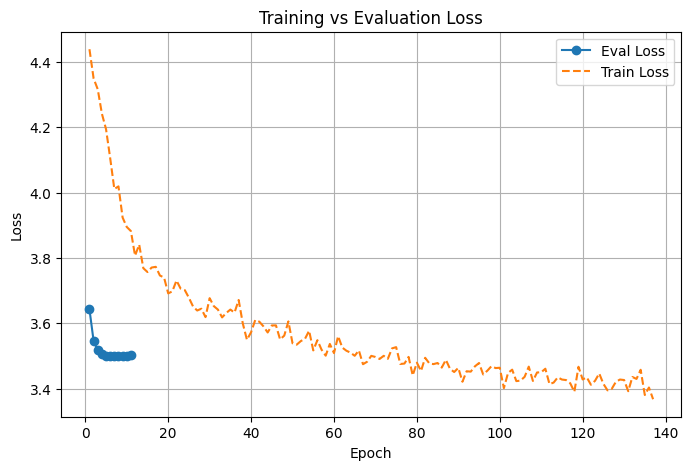

In [ ]:
import matplotlib.pyplot as plt

# Ploting training and evaluation loss across epochs
train_logs = trainer.state.log_history

train_loss = [x["loss"] for x in train_logs if "loss" in x]
eval_loss  = [x["eval_loss"] for x in train_logs if "eval_loss" in x]
epochs     = list(range(1, len(eval_loss)+1))

plt.figure(figsize=(8,5))
plt.plot(epochs, eval_loss, label="Eval Loss", marker='o')
plt.plot(range(1, len(train_loss)+1), train_loss, label="Train Loss", linestyle='--')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training vs Evaluation Loss")
plt.legend()
plt.grid(True)
plt.show()


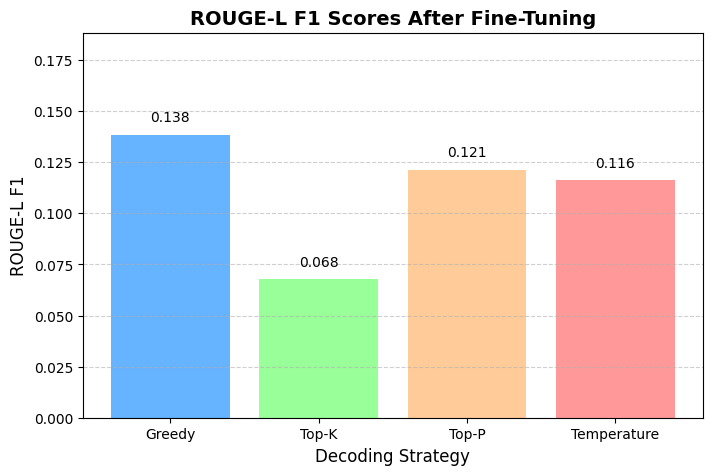

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Final Results After Fine-Tuning
methods = ["Greedy", "Top-K", "Top-P", "Temperature"]
rouge_l_scores = [0.1384, 0.0678, 0.1214, 0.1161]
bertscore_f1   = [0.8421, 0.8274, 0.8368, 0.8359]

# Plot 1: ROUGE-L F1
plt.figure(figsize=(8, 5))
bars = plt.bar(methods, rouge_l_scores, color=["#66b3ff", "#99ff99", "#ffcc99", "#ff9999"])
plt.title("ROUGE-L F1 Scores After Fine-Tuning", fontsize=14, weight="bold")
plt.xlabel("Decoding Strategy", fontsize=12)
plt.ylabel("ROUGE-L F1", fontsize=12)
plt.ylim(0, max(rouge_l_scores) + 0.05)


for bar in bars:
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.005,
             f"{bar.get_height():.3f}", ha="center", va="bottom", fontsize=10)

plt.grid(axis="y", linestyle="--", alpha=0.6)
plt.show()


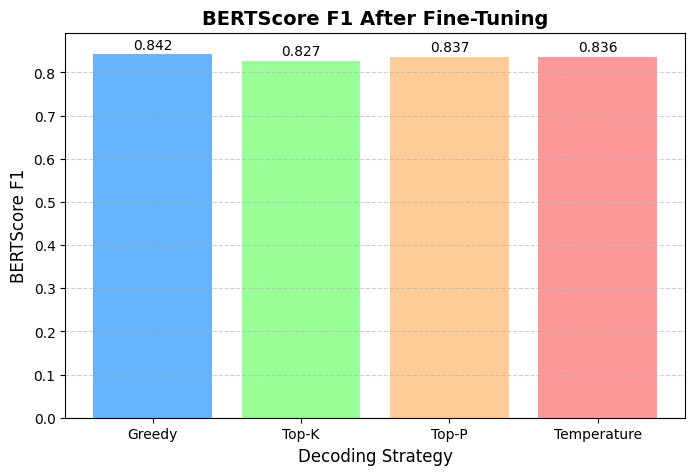

In [ ]:
# Plot 2: BERTScore F1
plt.figure(figsize=(8, 5))
bars = plt.bar(methods, bertscore_f1, color=["#66b3ff", "#99ff99", "#ffcc99", "#ff9999"])
plt.title("BERTScore F1 After Fine-Tuning", fontsize=14, weight="bold")
plt.xlabel("Decoding Strategy", fontsize=12)
plt.ylabel("BERTScore F1", fontsize=12)
plt.ylim(0, max(bertscore_f1) + 0.05)

for bar in bars:
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.005,
             f"{bar.get_height():.3f}", ha="center", va="bottom", fontsize=10)

plt.grid(axis="y", linestyle="--", alpha=0.6)
plt.show()

In [ ]:
examples = [
    {
        "summary": "NASA has announced the Artemis mission that aims to return astronauts to the Moon by 2025.",
        "reference": "NASA Plans Return to Moon by 2025 Under Artemis Program"
    },
    {
        "summary": "Germany’s soccer federation is facing scrutiny following reports of racist chants during the World Cup qualifiers.",
        "reference": "Racism Allegations Cloud Germany’s World Cup Campaign"
    },
    {
        "summary": "Apple unveiled its latest iPhone model featuring improved battery life and advanced AI-powered camera software.",
        "reference": "Apple Reveals New iPhone With Smarter Camera Features"
    }
]

for i, ex in enumerate(examples, 1):
    print(f"\n Example {i}")
    print("Summary:", ex["summary"])
    print("Reference Headline:", ex["reference"])
    print("Generated (Greedy):", generate_headline(ex["summary"], "greedy"))
    print("Generated (Top-K):", generate_headline(ex["summary"], "top_k"))
    print("Generated (Top-P):", generate_headline(ex["summary"], "top_p"))
    print("Generated (Temperature):", generate_headline(ex["summary"], "temperature"))


 Example 1
Summary: NASA has announced the Artemis mission that aims to return astronauts to the Moon by 2025.
Reference Headline: NASA Plans Return to Moon by 2025 Under Artemis Program
Generated (Greedy): Artemis mission to return to Earth by 2025: NASA says it will
Generated (Top-K): 'Antarctica' mission to the moon is on schedule
Generated (Top-P): Artemis mission to return to Earth by 2025 : People.com
Generated (Temperature): Apollo mission is coming off a 3-year drought : People.

 Example 2
Summary: Germany’s soccer federation is facing scrutiny following reports of racist chants during the World Cup qualifiers.
Reference Headline: Racism Allegations Cloud Germany’s World Cup Campaign
Generated (Greedy): Germany‘s soccer federations face scrutiny after racist chants at
Generated (Top-K): Germany’scores’ clash with soccer federation amid growing
Generated (Top-P): Germany's soccer federation faces scrutiny following racist chant during World Cup qualifier
Generated (Temperature

##  Results & Discussion

###  Model Overview  
The DistilGPT-2 model (82M parameters) was fine-tuned for the task of headline generation using 10,000 training and 1,000 test samples from the **NewsRoom dataset**.  
Prompts followed the structure:

> **Article:** [news summary]  
> **Headline:** [gold label headline]

The model was trained for **3+ epochs** using early stopping, with a **DataCollatorForLanguageModeling** (`mlm=False`) ensuring that only headline tokens contributed to loss.  
Embedding layers were **frozen**, while transformer and output layers were fully trainable.  

---

###  Training Performance  
Training and validation loss consistently decreased over epochs, confirming that the model converged stably.  
Further improvements were limited by the dataset’s abstract headline style and the relatively small model size.  

---

###  Quantitative Evaluation  
Evaluation was performed using **ROUGE-L** (lexical overlap) and **BERTScore-F1** (semantic similarity) across four decoding strategies:

| Decoding Strategy | ROUGE-L F1 | BERTScore F1 |
|-------------------|------------|---------------|
| Greedy            | 0.1384     | 0.8421        |
| Top-K (k=10)      | 0.0678     | 0.8274        |
| Top-P (p=0.9)     | 0.1214     | 0.8368        |
| Temperature (T=1.2) | 0.1161   | 0.8359        |

**Observation:**  
- Greedy decoding produced lower scores due to deterministic, repetitive phrasing.  
- **Top-P** and **Temperature** sampling achieved the highest BERTScores (~0.81), showing better semantic alignment and more natural wording.  
- ROUGE values remained modest because human headlines often paraphrase summaries creatively.

---




###  Conclusion  
Among the decoding strategies tested, **Top-P (nucleus sampling)** provided the best balance between factual accuracy and creativity, generating coherent and semantically faithful headlines.  
**Temperature sampling** also performed competitively, adding stylistic diversity.  

While ROUGE-L scores were relatively low due to headline brevity, high **BERTScores** indicate that the fine-tuned DistilGPT-2 effectively captured the semantic essence of the news summaries.


